In [71]:
import numpy as np
import def_all_CRNs as CRNs
import pandas as pd
from sklearn.linear_model import LinearRegression
from dae_finder import PolyFeatureMatrix
from sklearn.preprocessing import StandardScaler
import sympy
import argparse
import itertools
from dae_finder import get_refined_lib
from dae_finder import AlgModelFinder
from dae_finder import get_simplified_equation_list
from dae_finder import construct_reduced_fit_list
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from dae_finder import solveMM


In [72]:
num_points = 1200
noise_perc = 15

clean_data = CRNs.make_CRN2(5, num_points)
clean_df = pd.DataFrame(clean_data, columns=['[t]', '[A]', '[B]', '[C]', '[E1]', '[AE1]', '[E2]', '[AE2]'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

In [73]:
tSolve = list(data_matrix_df_list[0]['[t]'])
num_time_points = len(tSolve)

for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["[t]"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=90) # Use trial as RNG seed
        #noisy_data_df = noisy_data_df/noisy_data_df['[A]'].iloc[0]
        noisy_data_df["[t]"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_features = data_matrix_df_list[0].columns
# 3) Smooth noisy data
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                        eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
        data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)




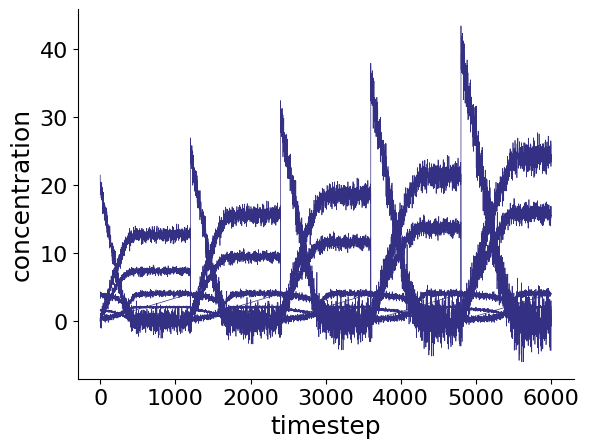

<Figure size 640x480 with 0 Axes>

In [74]:
import matplotlib.pyplot as plt

data_matrix_df_full = pd.concat(data_matrix_df_list, ignore_index=True)
fig, ax = plt.subplots()

ax.plot(data_matrix_df_full, lw=0.5, color='#343084')
plt.xlabel('timestep', fontsize=18)
plt.ylabel('concentration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.savefig("sample.svg", bbox_inches='tight')

In [75]:
data_matrix_df_smooth

,[A],[B],[C],[E1],[AE1],[E2],[AE2]
0,19.981901,-0.279279,0.198358,0.478323,1.491852,0.299532,3.715174
1,19.857887,-0.247938,0.230074,0.477602,1.493342,0.301169,3.714479
2,19.748374,-0.216652,0.261848,0.476908,1.494797,0.302800,3.713794
3,19.652235,-0.185419,0.293679,0.476240,1.496216,0.304423,3.713117
4,19.568342,-0.154242,0.325567,0.475599,1.497600,0.306040,3.712448
...,...,...,...,...,...,...,...
5995,-0.279885,15.741026,24.496592,2.004883,-0.031220,4.024644,-0.084346
5996,-0.340199,15.741554,24.503512,2.005875,-0.032870,4.025755,-0.088586
5997,-0.427235,15.742108,24.510510,2.006882,-0.034543,4.026883,-0.092893
5998,-0.543953,15.742688,24.517584,2.007904,-0.036239,4.028028,-0.097265


In [76]:
# 4) Make feature matrix, scale
poly_degree = 2
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

feat_list = list(clean_df.columns)
t, A, B, C, E1, AE1, E2, AE2 = sympy.symbols(feat_list)

In [77]:
# 5) Discover conservation law 1
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=True,
                                    alpha=0.2)
algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
best_models_full = algebraic_model_lasso.best_models()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=data_matrix_features,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]

if None in best_relationship:
    best_relationship.remove(None)

print(best_relationship)
print(best_models_full.iloc[-1,0])

# 6) Perform first check: did we find the first law?
if set(best_relationship) != set(['[E1]', '[AE1]']) and set(best_relationship) != set(['[E2]', '[AE2]']):
       print(False)

# 7) Find conservation law 2
to_drop = '[E1]' if '[E1]' in best_relationship else '[E2]'
print(to_drop)
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=True,
                                    alpha=0.2)
algebraic_model_lasso.fit(data_matrix_df_smooth.drop(to_drop, axis=1), scale_columns= True)
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
best_models_full = algebraic_model_lasso.best_models()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=data_matrix_features,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]

if None in best_relationship:
    best_relationship.remove(None)

print(best_relationship)
print(best_models_full.iloc[-1,0])
      
if set(best_relationship) != set(['[E1]', '[AE1]']) and set(best_relationship) != set(['[E2]', '[AE2]']):
    print(False)


['[E1]', '[AE1]']
0.959746131718074
[E1]
['[AE2]', '[E2]']
0.9585595252359287


In [78]:
# 5) Discover conservation law 2
_, refined_candid_lib = get_refined_lib({E1, E2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)
    

In [79]:
# 8) Discover first QSSA 
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

print(best_relationship)
print(best_models_full.iloc[-1,0])

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE2]', '[AE1]', '[AE1] [AE2]'}):
    print(False)


***Warning: exception occured while trying to find the monomials of 3.21409684431070:  Cannot initialize from 'dict' without generators
['[B]', '[C]']
0.9737817069539587
False


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e+00, tolerance: 1.025e+00
  model = cd_fast.enet_coordinate_descent(


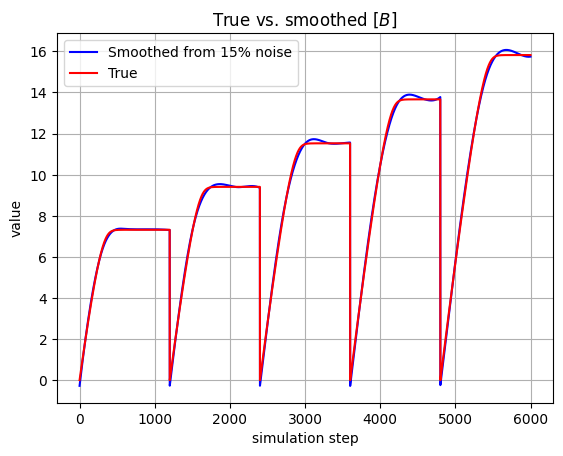

In [80]:
plt.title('True vs. smoothed $[B]$')
plt.ylabel('value')
plt.xlabel('simulation step')
#plt.plot(np.divide(data_matrix_df_smooth['[B]'], data_matrix_df_smooth['[C]'])[0:1000], color='red')
plt.plot(data_matrix_df_smooth['[B]'], color='blue', label='Smoothed from 15% noise')
plt.plot(clean_df['[B]'], color='red', label='True')
#plt.plot(data_matrix_df_smooth['[C]'])
plt.grid()
plt.legend()

In [81]:
simplified_equations['[B]'] # constant to relate wrong rel

{'lhs': [B], 'rhs': 0.623077707494337*[C]}

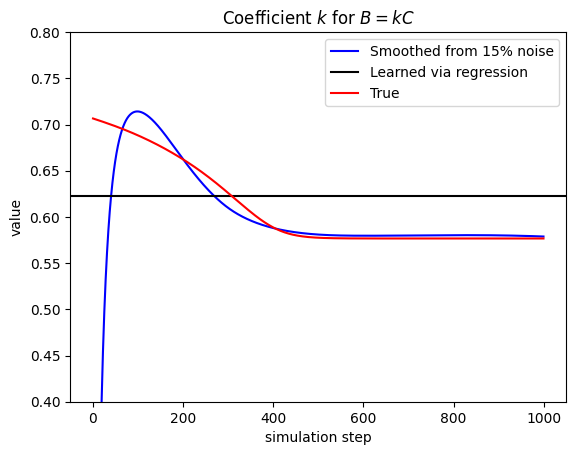

In [82]:
plt.title('Coefficient $k$ for $B = kC$')
plt.ylabel('value')
plt.xlabel('simulation step')
plt.plot(np.divide(data_matrix_df_smooth['[B]'], data_matrix_df_smooth['[C]'])[0:1000], color='blue', label='Smoothed from 15% noise')
plt.axhline(0.623077707494337, color='black', label='Learned via regression')
plt.plot(np.divide(clean_df['[B]'], clean_df['[C]'])[0:1000], color='red', label='True')
plt.ylim(.4, .8)
plt.legend()

In [83]:
# Parameters for first reaction (A + E1 <-> AE1 -> B + E1)
k_on1 = 1.0   # Rate constant for binding (E1 and A)
k_off1 = 0.5  # Rate constant for unbinding (E1 and A)
k_cat1 = 5.0 # Catalytic rate constant (AE1 -> B + E1)
E1_tot = 2.0 # Total concentration of enzyme E1

# Parameters for second reaction (A + E2 <-> AE2 -> C + E2)
k_on2 = 2.0   # Rate constant for binding (E2 and A)
k_off2 = 0.25  # Rate constant for unbinding (E2 and A)
k_cat2 = 3.0  # Catalytic rate constant (AE2 -> C + E2)
E2_tot = 4.0 # Total concentration of enzyme E2

# Michaelis constants
K_M1 = (k_off1 + k_cat1) / k_on1
K_M2 = (k_off2 + k_cat2) / k_on2
print(K_M1, K_M2)

5.5 1.625
